# Forberedelsen af data

In [1]:
#Libriaries & Models
import matplotlib
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.regularizers import l2


from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

import os
import pickle

import importlib
import src
importlib.reload(src)

2024-12-01 15:41:31.049842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.
Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Access the datasets

In [2]:
dataframes = src.dataset.load_dataframes()

Loaded from pickle


Data handling

In [3]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data()

# Konverter til 3D-format for LSTM (samples, timesteps, features)
# Her antages en enkelt timestep, men du kan øge det, hvis du vil have flere tidssteg
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Loaded from pickle


# Single Dense Model

In [4]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.5),
    Dense(units=y_train.shape[1], activation='relu')
])

model.compile(optimizer='adam', loss='mse')

/Users/hugojohnson/.virtualenvs/02456-deep-learning-project/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training the model

In [5]:
batchsize = 128
epochs = 20

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=0.2, verbose=1)

# Forudsig output for testdata
y_pred = model.predict(X_test)

print(y_pred)

# Omvend normalisering af y_pred og y_test
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# Beregn MSE
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, y_pred).numpy()
print("Mean Squared Error of test data:", mse_value)

# mse = MeanSquaredError(y_test, y_pred)
# print("Mean Squared Error på testdata:", mse)

Epoch 1/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0334 - val_loss: 0.0138
Epoch 2/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 3/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0107 - val_loss: 0.0144
Epoch 4/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0102 - val_loss: 0.0129
Epoch 5/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0100 - val_loss: 0.0114
Epoch 6/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0098 - val_loss: 0.0119
Epoch 7/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0096 - val_loss: 0.0141
Epoch 8/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0096 - val_loss: 0.0111
Epoch 9/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0095 - val_loss: 0.0119
Epoch 10/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0094 - val_loss: 0.0141
Epoch 11/20
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0094 - val_loss: 0.0128
Epoch 12/20
8001/80

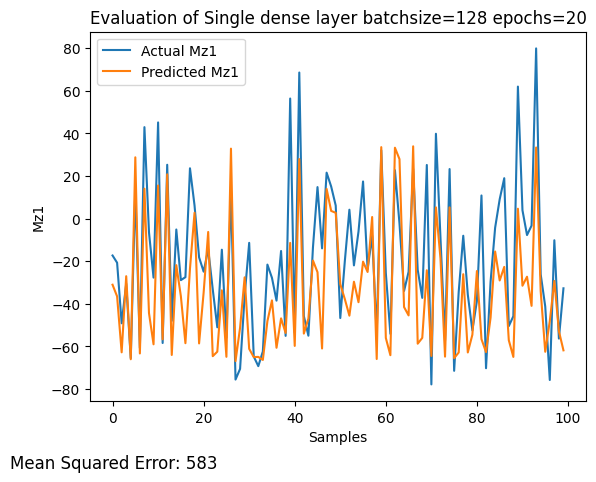

In [6]:
src.plots.evaluate_predictions(y_pred[:, 0][1000:1100], y_test[:, 0][1000:1100], mse(y_test, y_pred).numpy(), name=f"Single dense layer batchsize={batchsize} epochs={epochs}")

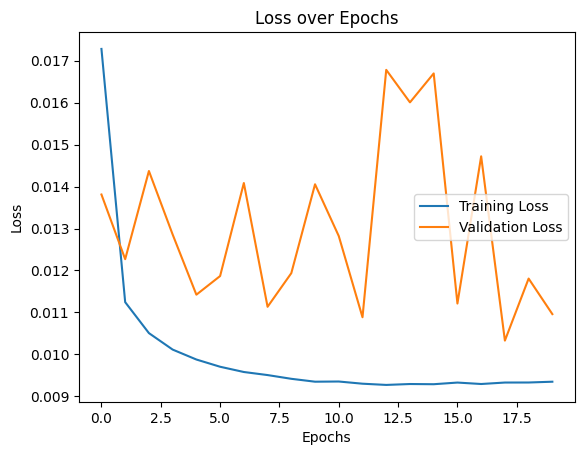

In [7]:
# Extract loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
